In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
weather = pd.read_pickle('data/weather_features')
old_features = pd.read_pickle('data/feature_engineering.pkl')
workday = pd.read_pickle('data/wd.pkl')

## Concatenating the different datasets + getting rid of columns, i'm not going to use

In [3]:
old_features = old_features.drop(['workday', 'shift_wd0', 'shift_wd1', 'shift_wd2', 'shift_wd3',
       'shift_wd4', 'shift_wd5', 'shift_wd6', 'shift_wd7', 'shift_wd8',
       'shift_wd9', 'shift_wd10', 'shift_wd11', 'shift_wd12', 'shift_wd13',
       'shift_wd14', 'shift_wd15', 'shift_wd16', 'shift_wd17', 'shift_wd18',
       'shift_wd19', 'shift_wd20', 'shift_wd21', 'shift_wd22', 'shift_wd23',
       'shift_wd24', 'shift_wd25', 'shift_wd26', 'shift_wd27', 'shift_wd28',
       'shift_wd29', 'shift_wd30', 'shift_wd31', 'shift_wd32', 'shift_wd33',
       'shift_wd34', 'shift_wd35'], axis=1) #dropping old workday predictions
weather = weather.drop(['flow'], axis=1) #dropping flow, since it's also in old_features
features = pd.concat([old_features, workday], axis=1, join='inner' )
features.rename(columns={'wd_label': 'workday'}, inplace=True)

In [4]:
features = pd.concat([features, weather], axis=1, join='inner')

In [5]:
def temp_shifter(data, num_shifts):
    
    for i in range(num_shifts):
        data[f'temp_mean{i}'] = data['temp_mean'].shift(24*(i+1))
        
    return data

In [6]:
def workday_shifter(data, num_shifts):
    
    for i in range(num_shifts):
        data[f'shift_wd{i}'] = data['workday'].shift(24*(i+1))
        
    return data

In [7]:
features = workday_shifter(features, 35)
# features = temp_shifter(features, 35) Doesn't seem to work since mse increases 

In [8]:
features = features[np.isfinite(features['shift_wd34'])]

In [9]:
target = features['flow']
features = features.drop(['flow'], axis=1)

### Scaling data such that PCA works better

In [10]:
sc = StandardScaler()
sc.fit(features)
std_features = sc.transform(features)

### Doing PCA Settling for 12 features, since they all capture > 2 % of variance

In [11]:
pca = PCA(n_components=12)
pca.fit(std_features)

PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [12]:
print(pca.explained_variance_ratio_)

[0.12124346 0.11036921 0.09128313 0.08589707 0.0553392  0.04385284
 0.04240834 0.04053762 0.03896494 0.03704366 0.02957926 0.02001026]


### The 12 new features can explain for around 72 % of variance in flow

In [13]:
pca.explained_variance_ratio_.sum()

0.7165289937688305

In [14]:
std_features_df = pd.DataFrame(std_features, index=features.index)

## Running RandomForestRegressor on a random split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

In [16]:
rf = RandomForestRegressor()

In [17]:
rf.fit(pca.transform(X_train), y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [18]:
pred = rf.predict(pca.transform(X_test))

In [19]:
score_list = np.array([np.abs(pred[i] - y_test[i]) for i in range(pred.shape[0])])

## Trying now instead to split it timeseries wise instead => easier illustrations and visual valuation

In [20]:
new_data = pd.concat([features, target], axis=1, join='inner')

In [21]:
import datetime
train = new_data[new_data.index < datetime.datetime(2017, 10, 4)]
test = new_data[new_data.index > datetime.datetime(2017, 11, 21)]

In [22]:
X_train = train.iloc[: , 0:-1]
y_train = train.iloc[:, -1:]

In [23]:
X_test = test.iloc[:, 0:-1]
y_test = test.iloc[:, -1:]

In [24]:
rf2 = RandomForestRegressor()
rf2.fit(pca.transform(X_train), y_train)
pred = rf2.predict(pca.transform(X_test))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [25]:
mean_error = np.array([pred[i] - y_test.iloc[i, 0] for i in range(pred.shape[0])])

In [26]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.abs(ret[n - 1:] / n)

In [27]:
plt.plot(moving_average(mean_error, n=25))

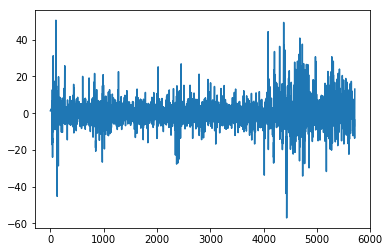

In [28]:
plt.plot(mean_error)

### Around drought=10 the predictions are more more imprecise. 

In [29]:
np.median(moving_average(mean_error, n=10)) * 365 * 24

13965.342034962849

In [30]:
mean_error.sum()

2234.1197751447216

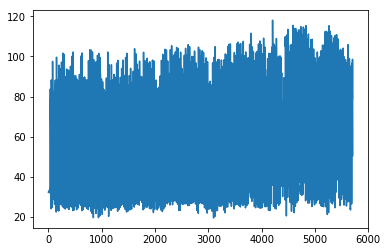

In [31]:
plt.plot(pred)

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


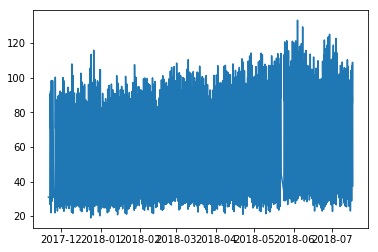

In [32]:
plt.plot(y_test)

### Looks pretty similar, but the predictions are on average wrong by 4 m3/h, which is approx 38,000 m3/year. in absolute values

In [33]:
features['extreme_drought'] = features['drought'] == 10

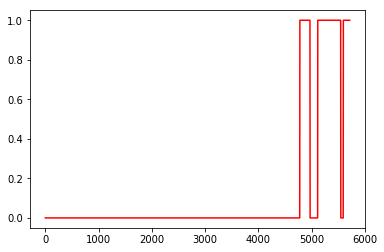

In [34]:
plt.plot(range(0,5712), features.extreme_drought[-5712:], color='red')

### The new feature may not add a lot of novelty, since drought = 10 is relatively rare => low variance in parameter. I will try anyway

In [35]:
sc = StandardScaler()
features = features.drop(['shift_flow0'], axis=1)
sc.fit(features)
std_features = sc.transform(features)

pca = PCA(n_components=12)
pca.fit(std_features)

new_data = pd.concat([features, target], axis=1, join='inner')
train = new_data[new_data.index < datetime.datetime(2017, 10, 4)]
test = new_data[new_data.index > datetime.datetime(2017, 11, 21)]

X_train = train.iloc[: , 0:-1]
y_train = train.iloc[:, -1:]

X_test = test.iloc[:, 0:-1]
y_test = test.iloc[:, -1:]

rf3 = RandomForestRegressor()
rf3.fit(pca.transform(X_train), y_train)
pred = rf3.predict(pca.transform(X_test))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [36]:
rf3.feature_importances_

array([0.0553532 , 0.6111608 , 0.0984963 , 0.02322757, 0.05228868,
       0.03484432, 0.0889562 , 0.01058658, 0.00778109, 0.00595826,
       0.00629056, 0.00505644])

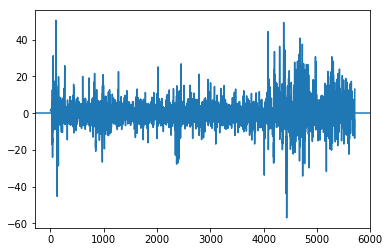

In [37]:
plt.plot(mean_error)
plt.axhline(y=0)

In [38]:
mean_error = np.array([ np.abs(pred[i] - y_test.iloc[i, 0]) for i in range(pred.shape[0])])

(array([2333., 1516.,  769.,  394.,  231.,  148.,   86.,   53.]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 <a list of 8 Patch objects>)

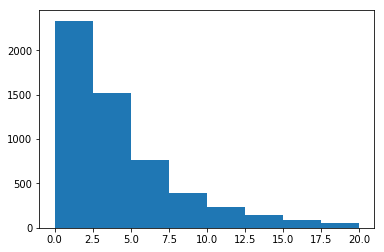

In [39]:
plt.hist(mean_error, bins=[0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20])

In [40]:
mean_error.mean() / y_test.mean()

flow    0.07553
dtype: float64

###  The prediction is on average 7% off, however centered around the true value. 

In [41]:
plt.plot(pred)

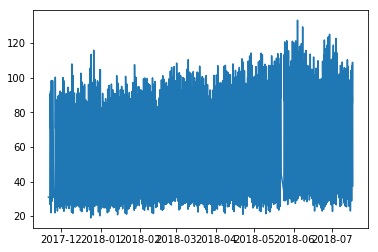

In [42]:
plt.plot(y_test)

## Trying the same methodology on deleaked data 

In [98]:
deleaked = pd.read_pickle('data/deleak_series')

In [99]:
features_deleaked = pd.concat([old_features, deleaked], axis=1, join='inner')

In [100]:
features_deleaked = features_deleaked.drop(['flow'], axis=1)
features_deleaked.rename(columns={0 : 'flow'}, inplace=True)

In [101]:
features_deleaked.drop(['shift_flow0', 'shift_flow1', 'shift_flow2', 'shift_flow3', 'shift_flow4', 'shift_flow5', 'shift_flow6', 'shift_flow7', 'shift_flow8', 'shift_flow9', 'shift_flow10', 'shift_flow11', 'shift_flow12', 'shift_flow13', 'shift_flow14', 'shift_flow15', 'shift_flow16', 'shift_flow17', 'shift_flow18', 'shift_flow19', 'shift_flow20', 'shift_flow21', 'shift_flow22', 'shift_flow23', 'shift_flow24', 'shift_flow25', 'shift_flow26', 'shift_flow27', 'shift_flow28', 'shift_flow29', 'shift_flow30', 'shift_flow31', 'shift_flow32', 'shift_flow33', 'shift_flow34', 'shift_flow35'], axis=1, inplace=True)

In [102]:
def flow_shifter(data, num_shifts):
    
    for i in range(1, num_shifts+1):
        data[f'flow_shift{i}'] = data['flow'].shift(i)
        
    return data

In [103]:
features_deleaked = flow_shifter(features_deleaked, 35)

In [104]:
features_deleaked = features_deleaked[np.isfinite(features_deleaked['flow_shift35'])]

In [105]:
target_deleaked = features_deleaked['flow']
features_deleaked = features_deleaked.drop(['flow'], axis=1)

In [106]:
sc = StandardScaler()
sc.fit(features_deleaked)
std_features = sc.transform(features_deleaked)

In [107]:
pca = PCA(n_components=12)
pca.fit(std_features)

PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [108]:
print(pca.explained_variance_ratio_)

[0.3081236  0.2757905  0.11218287 0.10944546 0.10058353 0.0124872
 0.01108056 0.01050701 0.00844034 0.0077941  0.00754422 0.00576267]


In [109]:
pca.explained_variance_ratio_.sum()

0.9697420671266829

In [110]:
std_features_df = pd.DataFrame(std_features, index=features_deleaked.index)

In [111]:
X_train, X_test, y_train, y_test = train_test_split(features_deleaked, target_deleaked, test_size=0.33, random_state=42)

In [112]:
rf = RandomForestRegressor()

In [113]:
rf.fit(pca.transform(X_train), y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [114]:
pred = rf.predict(pca.transform(X_test))

In [115]:
new_data = pd.concat([features_deleaked, target_deleaked], axis=1, join='inner')

In [116]:
import datetime
train = new_data[new_data.index < datetime.datetime(2017, 10, 4)]
test = new_data[new_data.index > datetime.datetime(2017, 11, 21)]

In [117]:
X_train = train.iloc[: , 0:-1]
y_train = train.iloc[:, -1:]

In [118]:
X_test = test.iloc[:, 0:-1]
y_test = test.iloc[:, -1:]

In [119]:
rf2 = RandomForestRegressor()
rf2.fit(pca.transform(X_train), y_train)
pred = rf2.predict(pca.transform(X_test))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [120]:
mean_error = np.array([pred[i] - y_test.iloc[i, 0] for i in range(pred.shape[0])])

In [121]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.abs(ret[n - 1:] / n)

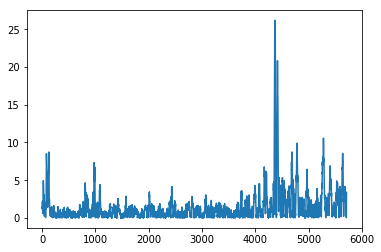

In [122]:
plt.plot(moving_average(mean_error, n=25))

In [123]:
plt.plot(pred)

In [124]:
plt.plot(y_test)

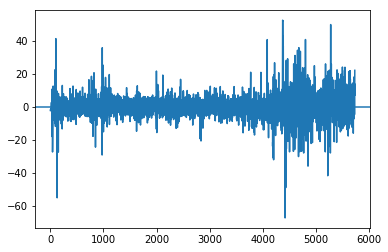

In [125]:
plt.plot(mean_error)
plt.axhline(y=0)

In [129]:
print(moving_average(mean_error, 1).mean().round(3), mean_error.mean().round(3))

4.459 0.343


In [132]:
moving_average(mean_error, 1).mean() / y_test.mean()

flow    0.077859
dtype: float64

###  Not suprisingly, deleaked data yields (almost) the same results as non-deleaked

So where does this leave us? We are certainly able to predict pretty acurately the flow of the next hour. Possibly also of the next day. 

### Next step:

... Maybe honing the feature engineering a bit more, and then proceeding to finding a way to decide if there is a leak or not. 

... One direction would be to compare different sections/utilities 